In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from empyrical import max_drawdown, alpha, beta
from sklearn.preprocessing import MinMaxScaler
from src.asset_selector import AssetSelector
from src.indicator_collection import IndicatorCollection
from util import time_formatter
from src.predictor import Predictor
from sklearn.cluster import KMeans
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import numpy as np
import configparser
import requests
import json
import time
import sys
import os

config = configparser.ConfigParser()
try:
    config.read(os.path.relpath("config.ini"))
except FileExistsError as e:
    print("FileExistsError: {}".format(e))
    sys.exit(1)
alpaca_api = tradeapi.REST(
    base_url    = config["alpaca"]["APCA_API_BASE_URL"],
    key_id      = config["alpaca"]["APCA_API_KEY_ID"],
    secret_key  = config["alpaca"]["APCA_API_SECRET_KEY"],
    api_version = config["alpaca"]["VERSION"]
)
trading_account = alpaca_api.get_account()
sid = SentimentIntensityAnalyzer()

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib

In [2]:
def get_sentiment(text):
    """Given a text block, return a sentiment score based.

    :param text:
    :return:
    """
    text_polarity   = sid.polarity_scores(text)
    print(text_polarity)

    if text_polarity["compound"] > 0.50:
        sentiment   = "positive"

    else:
        sentiment   = "negative"

    return sentiment

def get_losers():
    
    print('Losers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Loss')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers("losers"))):
        print(alpaca_api.polygon.gainers_losers("losers")[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChangePerc)+'%')
def get_gainers():
    print('Gainers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Gain')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers())):
        print(alpaca_api.polygon.gainers_losers()[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers()[symbol].todaysChangePerc)+'%')
        
if __name__ == '__main__':
    
    get_gainers()
    print()
    get_losers()

                   Gainers                   

Symbol     Last        Change      Pct Gain
–––––––––––––––––––––––––––––––––––––––––––––
NXTC       $89.9       $63.47      240.144%
AGFSW      $0.01       $0.005      96.078%
ENTXW      $0.3794     $0.179      89.7%
  0         $11028101626593.28 $5196379913799.598 89.105%
AMRHW      $0.02       $0.009      77.433%
AGRX       $2.8        $1.02       75.439%
AGRX       $13.1       $1.02       39.362%
SLS        $0.195      $3.7        39.362%
NIO        $2.35       $0.054      37.427%
NIO        $7575635115376.64 $1743913402582.958 29.904%
CHEKW      $0.039      $0.009      29.568%
ESTR       $0.232      $0.052      28.889%
FRTA       $10.97      $2.45       28.756%
EVER       $27.92      $6.15       28.25%
FPAYW      $0.77       $0.16       26.23%
CHNR       $1.7        $0.35       25.926%
ACPr       $0.3072     $0.062      25.337%
PRTK       $3.98       $0.8        25.157%
DFFN       $0.81       $0.16       24.615%
ACOR       $2.48     

In [3]:
ticker = "SGOL"

In [ ]:
selector    = AssetSelector(alpaca_api, edgar_token=None)
indicators  = IndicatorCollection(alpaca_api)

In [5]:
weeks = 13
backdate = time_formatter(time.time() - (604800 * weeks))

In [6]:
day_bars            = selector.get_barset(ticker, "day", backdate)
day_bars            = selector.extract_bar_data(day_bars, ticker)
minute_bars         = selector.get_barset(ticker, "minute", backdate)
minute_bars         = selector.extract_bar_data(minute_bars, ticker)
day_spy_bars        = selector.get_barset("SPY", "1D", backdate)
day_spy_bars        = selector.extract_bar_data(day_spy_bars, "SPY")
minute_spy_bars     = selector.get_barset("SPY", "minute", backdate)
minute_spy_bars     = selector.extract_bar_data(minute_spy_bars, "SPY")

In [9]:
# alpaca_api.polygon.historic_trades(ticker, '2019-10-10', limit=10)
# alpaca_api.polygon.news(ticker)
# alpaca_api.polygon.last_trade(ticker)
# alpaca_api.polygon.last_quote(ticker)
# alpaca_api.polygon.company(ticker)
# alpaca_api.polygon.dividends(ticker)

In [11]:
results = requests.post("https://api.stocktwits.com/api/2/streams/symbol/{}.json".format(ticker))
results = json.loads(results.text)

In [12]:
bodies = "\n".join([m["body"] for m in results["messages"]])
sentiment = get_sentiment(bodies)
sentiment

In [17]:
ticker_cluster = indicators.cluster_prep(ticker)

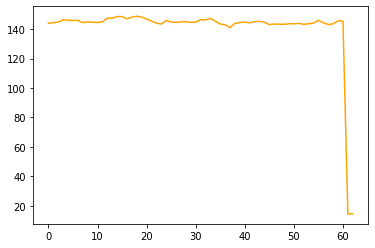

In [19]:
plt.plot(ticker_cluster["open"], color="orange")

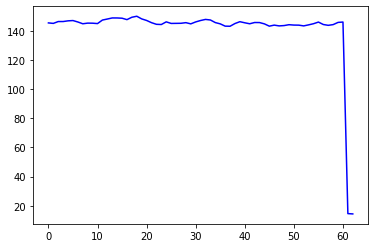

In [20]:
plt.plot(ticker_cluster["high"], color="blue")

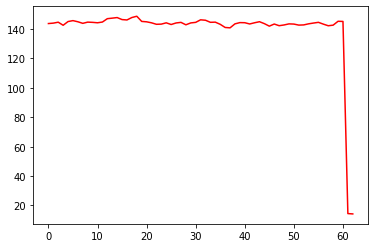

In [21]:
plt.plot(ticker_cluster["low"], color="red")

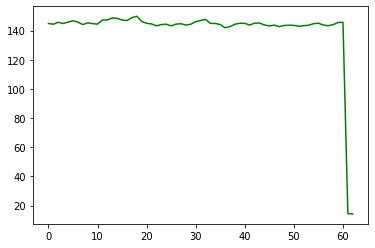

In [22]:
plt.plot(ticker_cluster["close"], color="green")

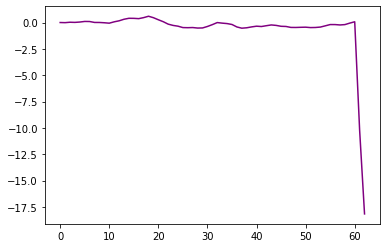

In [23]:
plt.plot(ticker_cluster["macd"], color="purple")

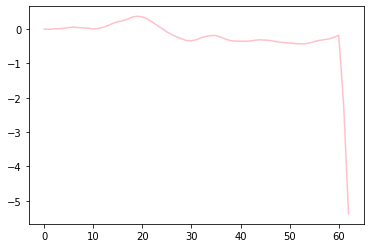

In [24]:
plt.plot(ticker_cluster["signal"], color="pink")

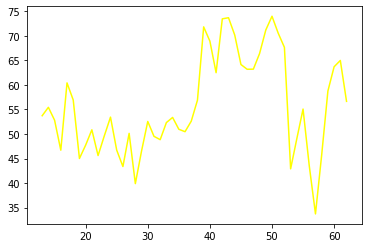

In [25]:
plt.plot(ticker_cluster["mfi"], color="yellow")

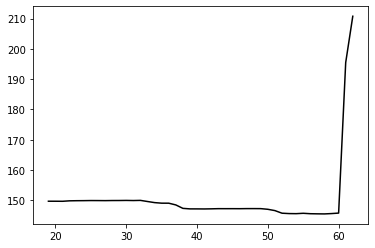

In [26]:
plt.plot(ticker_cluster["bb_up"], color="black")

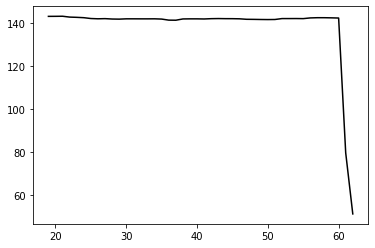

In [27]:
plt.plot(ticker_cluster["bb_low"], color="black")

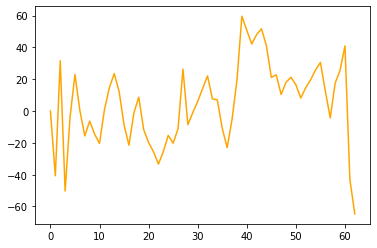

In [28]:
plt.plot(ticker_cluster["vzo"], color="orange")

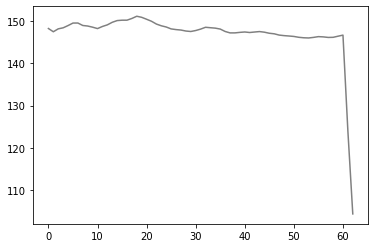

In [29]:
plt.plot(ticker_cluster["apz_u"], color="grey")

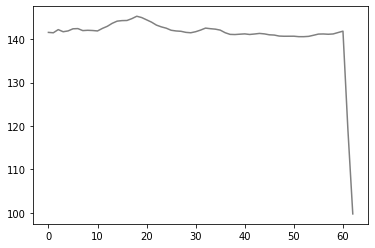

In [30]:
plt.plot(ticker_cluster["apz_l"], color="grey")

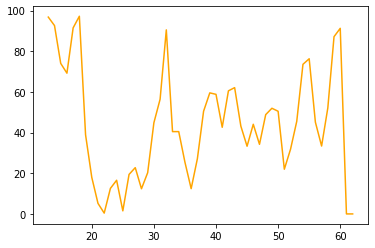

In [31]:
plt.plot(ticker_cluster["stoch"], color="orange")

In [32]:
# plt.plot(ticker_cluster["adx"], color="green")

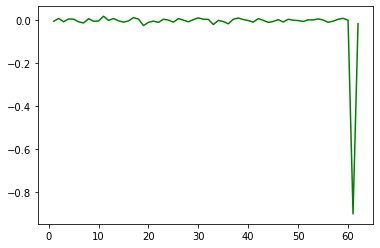

In [33]:
plt.plot(ticker_cluster["close"].pct_change(), color="green")

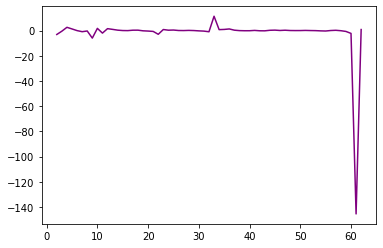

In [34]:
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")

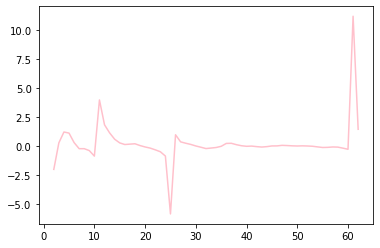

In [35]:
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")

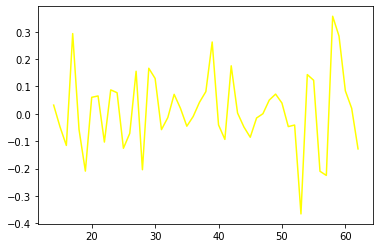

In [36]:
plt.plot(ticker_cluster["mfi"].pct_change(), color="yellow")

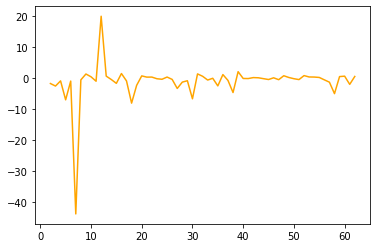

In [37]:
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")

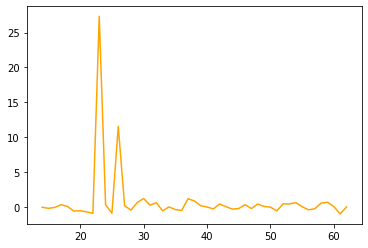

In [38]:
plt.plot(ticker_cluster["stoch"].pct_change(), color="orange")

In [39]:
vwap = indicators.get_vwap(minute_bars)

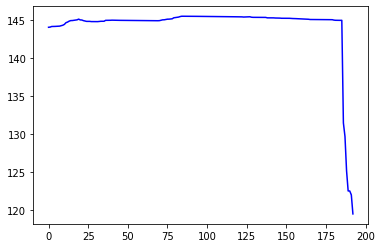

In [40]:
plt.plot(vwap, color="blue")

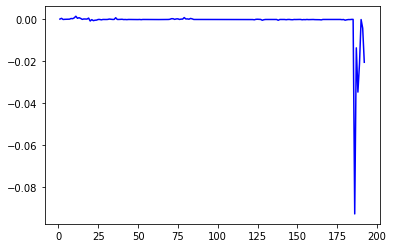

In [41]:
plt.plot(vwap.pct_change(), color="blue")

In [42]:
minute_macd = indicators.get_macd(minute_bars)

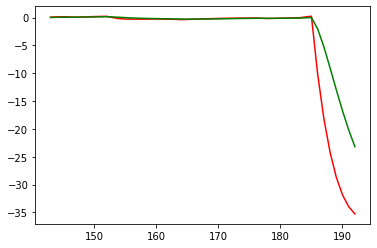

In [43]:
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")

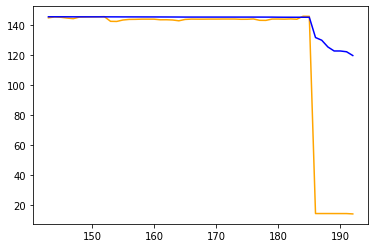

In [44]:
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(vwap.iloc[-50:], color="blue")

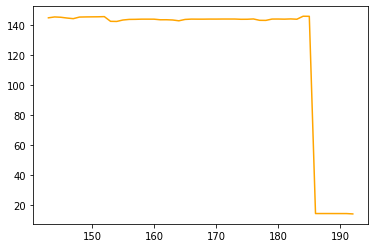

In [45]:
plt.plot(minute_bars["close"].iloc[-50:], color="orange")

In [46]:
# Feature Scaling Normalization
close_prices = pd.DataFrame(minute_bars["close"])
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(close_prices)

In [47]:
# calculate the max drawdown
max_drawdown = max_drawdown(minute_bars["close"])
day_bars.iloc[-50:]

In [51]:
day_spy_bars.iloc[-50:]

,time,open,high,low,close,volume
13,2019-08-27 00:00:00-04:00,289.54,289.9500,286.0300,286.8400,57062542
14,2019-08-28 00:00:00-04:00,286.14,289.0700,285.2500,288.8400,50136080
15,2019-08-29 00:00:00-04:00,291.72,293.1600,290.6100,292.5600,46853904
16,2019-08-30 00:00:00-04:00,294.22,294.2399,291.4200,292.4527,49059839
17,2019-09-03 00:00:00-04:00,290.57,291.5800,289.2700,290.7750,52837823
18,2019-09-04 00:00:00-04:00,293.14,294.0550,292.3100,293.9700,38261914
19,2019-09-05 00:00:00-04:00,296.79,298.8300,294.0010,297.8200,68516970
20,2019-09-06 00:00:00-04:00,298.17,298.7600,297.4200,298.0700,39903355
21,2019-09-09 00:00:00-04:00,299.14,299.2400,297.1600,298.1500,44162496
22,2019-09-10 00:00:00-04:00,297.36,298.2000,295.9700,298.2000,48742185


In [52]:
# calculate alpha and beta
alpha = alpha(minute_bars["close"], minute_spy_bars["close"])
beta = beta(minute_bars["close"], minute_spy_bars["close"])

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/empyrical/stats.py:1294: RuntimeWarning:

overflow encountered in power



In [53]:
print(alpha, beta, max_drawdown)

inf